# **Low-resource LLMs**

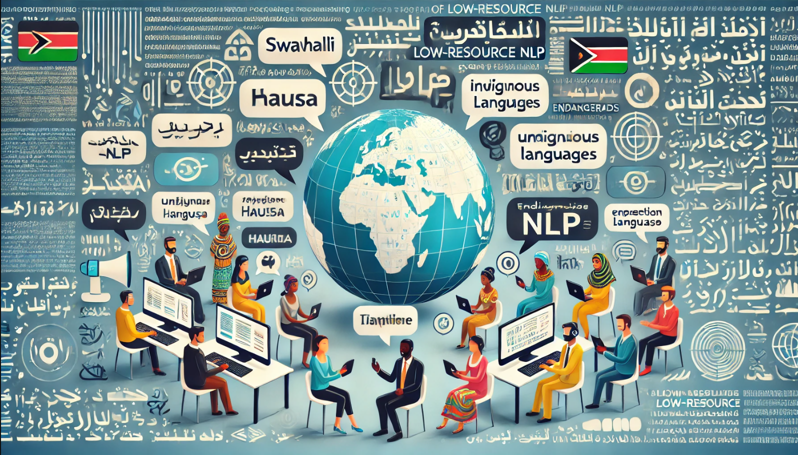




<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/Low_Resource_LLMs/Indaba_2024_Low_Resource_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

© Deep Learning Indaba 2024. Apache License 2.0.

**Authors:**
- Ali Zaidi
- Aya Salama
- Khalil Mrini
- Steven Kolawole

**Introduction:**

Low-resource NLP (Natural Language Processing) refers to the study and development of NLP models and systems for languages, tasks, or domains that have limited data and resources available. These can include languages with fewer digital text corpora, limited computational tools, or less-developed linguistic research.

**Key Challenges in Low-Resource NLP**

1. **Data Scarcity:**
   - **Limited Training Data:** Many languages lack large annotated corpora necessary for training NLP models.
   - **Lack of Pre-trained Models:** Popular NLP models like BERT, GPT, and others are often not available for low-resource languages.

2. **Linguistic Diversity:**
   - **Morphological Complexity:** Some languages have complex grammatical structures and morphological richness.
   - **Dialectal Variations:** A lack of standardized versions can complicate NLP tasks.

3. **Resource Limitations:**
   - **Computational Constraints:** Low-resource scenarios often involve limited access to computational power and storage.
   - **Expertise and Tools:** Fewer linguistic experts and fewer NLP tools are tailored for these languages.

**Topics:**

Content: Natural Language Processing, Low-resource, Large Language Models, Parameter Efficient Finetuning, Adaptation  
Level: Intermediate


**Aims/Learning Objectives:**

- Exploring data scarcity challenges
- Exploring Compute resource limitations and addressing them with Parameter efficient finetuning
- Comparing Performance between fine-tuned mt5, Bert-based models and a GPT-based Language model on low-resource languages/tasks
  

**Prerequisites:**

- [LLM Foundations practical](https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/Foundations_of_LLMs/foundations_of_llms_practical.ipynb)



**Outline:**

>[Setup](#scrollTo=wslj6xaTPR-D)

>>[Run cell to setup the needed packages and resources](#scrollTo=eE6olWFpPR-E)

>>[Imports](#scrollTo=Q7kzqCkyPR-F)

>[Introduction](#scrollTo=85IQK28VPR-F)

>>[What we will do:](#scrollTo=HmX8ef0uPR-F)

>>[Evaluation Metric: ROUGE](#scrollTo=KtYLZ9loPR-F)

>>>[Key ROUGE Variants](#scrollTo=KtYLZ9loPR-F)

>>>[How ROUGE is Computed](#scrollTo=KtYLZ9loPR-F)

>>>[Importance of ROUGE](#scrollTo=KtYLZ9loPR-F)

>>>>[NOTE: Caveat](#scrollTo=KtYLZ9loPR-F)

>>[Load dataset](#scrollTo=eiqKu07MPR-F)

>>[Check dataset](#scrollTo=4cjG8W9iPR-G)

>[Section 1: Efficiently Fine-Tune Seq2Seq Models with Low Rank Adaptation (LoRA)](#scrollTo=yYkzmZO9PR-G)

>>>[Quick intro to PEFT or Parameter Efficient Fine-tuning](#scrollTo=mzDyMEKByxLU)

>>[Low-Rank Adaptation (LoRA)](#scrollTo=AtgK-3iMPR-G)

>>>[How Does LoRA Work?](#scrollTo=AtgK-3iMPR-G)

>>[Summarization Using MT5](#scrollTo=m25VCT7RPR-G)

>>[Evaluation 1: LoRA mT5 Model](#scrollTo=SlBMw-xNyxLb)

>>[Evaluation 2: Evaluation on Already-Finetuned Bert-Based Models](#scrollTo=Yy6YM9GdPR-K)

>[Activity: Native Language Article Summarization](#scrollTo=WH1Qcxd3PR-K)

>[Section 2: Summarization using GPT](#scrollTo=lXgW_EWSPR-K)

>>[Execute the summarization on sample of Goud-sum](#scrollTo=kQBh6s0OPR-L)

>>[Evaluation of GPT4o-mini on sample of Goud-sum](#scrollTo=C0h5qAi6f8j7)

>>[Evaluate Previously Generated GPT4 output on entire Goud-sum test set](#scrollTo=wrOv9fb3PR-L)

>>>[ROUGE Metric Results: 0 Shot](#scrollTo=d2Ad0a1jPR-L)

>>>[ROUGE Metric Results: Few-Shot](#scrollTo=V-Pc2PTjPR-L)

>>[Conclusion](#scrollTo=8s1NaD5bPR-L)

>>[Feedback](#scrollTo=e761XjLuPR-L)

**Before you start:**

Please run the next cells in the [Setup](#scrollTo=wslj6xaTPR-D) section to install the required packages and download the needed resources.

For this practical, it is preferable to use a GPU to speed up the flow. In Colab, go to the "Runtime" menu, select "Change runtime type" and then in the popup menu, choose "T4 GPU" in the "Hardware accelerator" box.

**Storyline:** working on a task with scarce data which is summarization in Moroccan Darija.
this task pose resources constrainst as the Moroccan Darija can be considered a low resource dialect of Arabic, we will set this task in a coumputational resource poor environment so our training should be able to run on a commodity GPU
we will be using parameter efficient fine tuning technique (LORA) to optimize the training procedure in order to make it feasible

# Setup

##  Run cell to setup the needed packages and resources

The resources you'll need to run this practical will be downloaded when you run the next cell.
First, the needed packages are going to be installed then other required resources like dataset, models and pre-generated response files.


After downloading and extraction are complete, you'll have the following folders present in the "resources" folder in the parent directory:
- *data* folder: this folder has the Goud-sum dataset that we will be utilizing in the pratical
- *genrated_responses* folder: this folder has pregenrated summaries that will be utilized in Section2

In [ ]:
!pip install datasets==2.16.1
!pip install evaluate==0.4.2
!pip install huggingface-hub==0.24.2
!pip install numpy==1.26.4
!pip install openai==1.39.0
!pip install peft==0.11.1
!pip install pyarrow==11.0.0
!pip install rouge-metric==1.0.1
!pip install rouge_score==0.1.2
!pip install torch==2.4.0
!pip install tqdm==4.66.4
!pip install transformers==4.43.1

Helper Functions

In [ ]:
import os
import time
import time
import pandas as pd
from tqdm import tqdm
from pathlib import Path


def load_existing_data(output_filename):
    """Load existing data from the CSV file if it exists."""
    if os.path.exists(output_filename):
        existing_df = pd.read_csv(output_filename)
        return existing_df.to_dict("records"), existing_df.shape[0]
    return [], 0


def handle_rate_limit_error(wait_time):
    """Handle rate limit errors by waiting and doubling the wait time."""
    print("Rate limit error")
    print(f"Waiting for {wait_time} seconds...", flush=True)
    time.sleep(wait_time)
    return wait_time * 2


def substring_after_colon(input_string):
    colon_index = input_string.find(":")
    if colon_index != -1:
        return input_string[colon_index + 1 :]
    else:
        return input_string


def summarize_news_article(
    test_source, base_prompt, output_filename, model_name, api_key, max_train=20
):
    """
    Summarize news articles into clickbait headlines in Moroccan Darija.

    Parameters:
    - test_source: List of news articles to summarize.
    - base_prompt: list of system messages and user (few-shot) messages.
    - output_filename: Name of the output CSV file.
    - model_name: Model name to use for the OpenAI API.
    - api_key: API key for the OpenAI API.
    - max_train: Maximum number of training examples to include in prompts.
    """
    from openai import OpenAI
    import openai

    client = OpenAI(api_key=api_key)
    df_lines, existing_len = load_existing_data(output_filename)
    rewritten_prompt_count = existing_len
    wait_time = 1

    for data in tqdm(
        test_source[existing_len:], desc=f"Processing lines from {existing_len}-th line"
    ):
        news_article = data.strip()
        made_error = True
        num_error = 0
        final_prompt = base_prompt.copy()  # Step 1: Copy the base prompt
        final_prompt.append(
            {  
                "role": "user",
                "content": f'Summarize the following news article into a headline in Moroccan Darija only:\n"{news_article}"',
            }
        )

        while made_error:
            try:
                response = client.chat.completions.create(
                    messages=final_prompt,
                    model=model_name,
                )
                headline = response.choices[0].message.content
                df_lines.append(
                    {
                        "article": news_article,
                        "generated_headline": headline,
                        "prompt_messages": final_prompt,
                    }
                )
                rewritten_prompt_count += 1
                made_error = False

            except Exception as e:
                if isinstance(e, openai.RateLimitError):
                    wait_time = handle_rate_limit_error(wait_time)
                else:
                    print(f"Error: {e}")
                    num_error += 1
                    print("Consider Reducing the shots_count to", max_train - num_error)

    df = pd.DataFrame.from_dict(df_lines)

    output_path = Path(output_filename)
    parent_dir = output_path.parent.absolute()
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir)
        print(f"Directory created: {parent_dir}")
    else:
        print(f"Directory already exists: {parent_dir}")
        
    df.to_csv(output_filename, index=False)
    print(f"Saved {rewritten_prompt_count} headlines to {output_filename}")


def load_models():
    import torch
    from peft import PeftModel, PeftConfig
    from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, EncoderDecoderModel

    # LoRA PEFT models
    config = PeftConfig.from_pretrained("alizaidi/lora-mt5-goud")
    base_model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")
    device_map = {"": 0} if torch.cuda.is_available() else None
    model = PeftModel.from_pretrained(
        base_model, "alizaidi/lora-mt5-goud", device_map=device_map
    )
    tokenizer = AutoTokenizer.from_pretrained("alizaidi/lora-mt5-goud")

    lora_goud = {
        "model": model,
        "tokenizer": tokenizer,
        "config": config,
    }

    # base models
    tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")
    model = AutoModelForSeq2SeqLM.from_pretrained("google/mt5-small")

    mt5_small = {
        "model": model,
        "tokenizer": tokenizer,
    }

    # load bert fine-tunes
    bert_finetune_names = [
        "Goud/AraBERT-summarization-goud",
        "Goud/DziriBERT-summarization-goud",
        "Goud/DarijaBERT-summarization-goud",
    ]
    bert_models = {}
    for model_name in bert_finetune_names:

        if (
            "AraBERT" in model_name
            or "DziriBERT" in model_name
            or "DarijaBERT" in model_name
        ):
            print(f"Loading model: {model_name}")
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = EncoderDecoderModel.from_pretrained(model_name)
        else:
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
        bert_models[model_name] = {
            "model": model,
            "tokenizer": tokenizer,
        }

    return lora_goud, mt5_small, bert_models

def download_and_extract_zip(url, extract_to="."):
    import requests, zipfile, io

    print(f"Starting download from {url}...")

    # Start the download process
    response = requests.get(url, stream=True)

    # Check if the download was successful
    if response.status_code == 200:
        total_size = int(response.headers.get("content-length", 0))
        print(f"Download complete. Extracting {total_size / (1024 * 1024):.2f} MB...")

        # Create a ZipFile object from the downloaded content
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Extract all the contents of the zip file into the specified directory
            z.extractall(path=extract_to)

            # Print the names of the extracted files
            extracted_files = z.namelist()
            print(f"Extracted {len(extracted_files)} files to '{extract_to}':")
            for file in extracted_files:
                print(f" - {file}")

        print("Download and extraction complete.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")


In [ ]:
# Download and extract the zip file containing the resources
download_and_extract_zip("https://dli2024prac.blob.core.windows.net/testres/resources.zip")


In [ ]:
lora_model, mt5_small, bert_models = load_models()

## Imports

In [ ]:
import numpy as np
import torch

from IPython.display import display, HTML
from tqdm import tqdm
from datasets import concatenate_datasets, load_from_disk
from evaluate import load
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PeftConfig, PeftModel
from rouge_metric import PyRouge
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, EncoderDecoderModel, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Introduction

This practical will revolve around generating headlines for news articles featured on the news website [Goud.ma](www.Gound.ma). 

We will frame this as a summarization task where the input is the body of a news article and the output is an appropriate headline. The [Goud-sum dataset](https://huggingface.co/datasets/Goud/Goud-sum) contains 158k articles and their headlines. All headlines are in Moroccan Darija, while articles may be in Moroccan Darija, in Modern Standard Arabic, or a mix of both (code-switched Moroccan Darija).

**Data Fields**
- *article*: a string containing the body of the news article
- *headline*: a string containing the article's headline
- *categories*: a list of string of article categories

In [ ]:
display(HTML(
    """
    <iframe
    src="https://huggingface.co/datasets/Goud/Goud-sum/embed/viewer/default/train"
    frameborder="0"
    width="100%"
    height="560px"
    ></iframe>
    """
))

## What we will do:

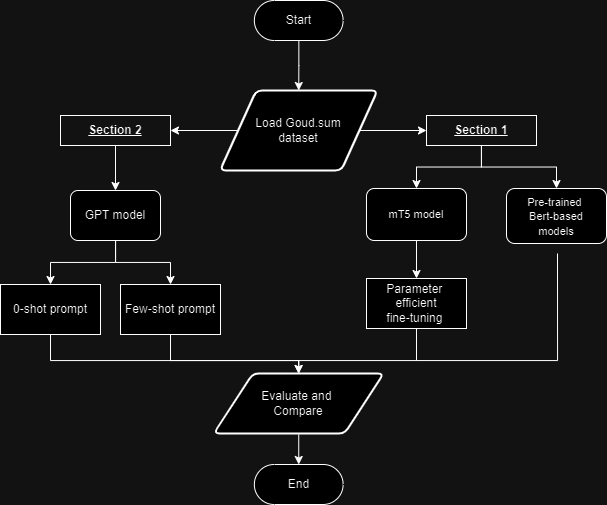

## Evaluation Metric: ROUGE

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate the quality of summaries by comparing them to reference (or ground truth) summaries. ROUGE is widely used in Natural Language Processing (NLP) tasks, particularly for evaluating the performance of text summarization models.

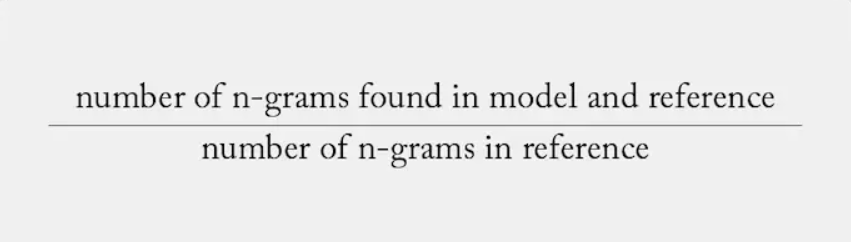

### Key ROUGE Variants

1. **ROUGE-N**: Measures the overlap of n-grams between the candidate summary and the reference summary.

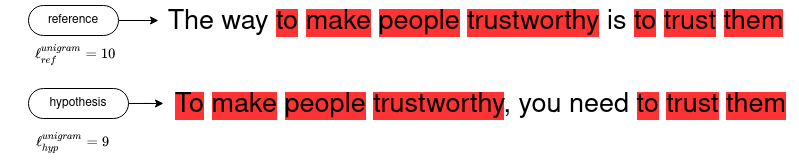

*caption:*
$ROUGE_1 = \frac{7}{10} = 0.7$

   - **ROUGE-1**: Overlap of unigrams (1-gram).
   - **ROUGE-2**: Overlap of bigrams (2-grams).
   - **ROUGE-L**: Measures the longest common subsequence (LCS) between the candidate and reference summaries.

2. **ROUGE-L**: Measures the longest common subsequence (LCS) between the candidate summary and the reference summary. Unlike ROUGE-N, ROUGE-L considers sentence-level structure similarity by identifying the longest co-occurring sequence of words in both summaries.



3. **ROUGE-W**: A weighted version of ROUGE-L that gives more importance to the contiguous LCS.

4. **ROUGE-S**: Measures the overlap of skip-bigrams, which are pairs of words in their order of appearance that can have any number of gaps between them.

### How ROUGE is Computed

ROUGE metrics can be calculated in terms of three measures:

- **Recall**: The ratio of overlapping units (n-grams, LCS, or skip-bigrams) between the candidate summary and the reference summary to the total units in the reference summary. It answers, "How much of the reference summary is captured by the candidate summary?"

- **Precision**: The ratio of overlapping units between the candidate summary and the reference summary to the total units in the candidate summary. It answers, "How much of the candidate summary is relevant to the reference summary?"

- **F1-Score**: The harmonic mean of Precision and Recall. This gives a balanced measure that considers both precision and recall.

### Importance of ROUGE

ROUGE is essential for summarization tasks because it provides a standardized way to evaluate and compare different summarization models. Higher ROUGE scores generally indicate that the candidate summary is more similar to the reference summary, meaning the model is likely performing well.


#### NOTE: Caveat

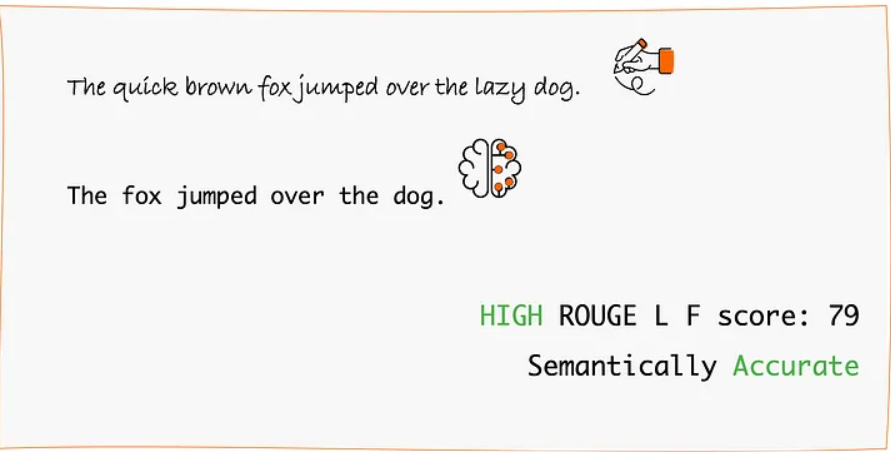

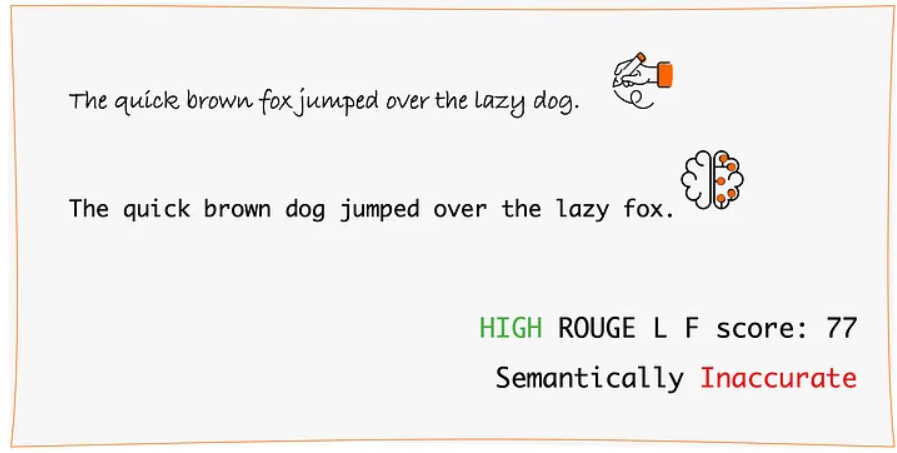

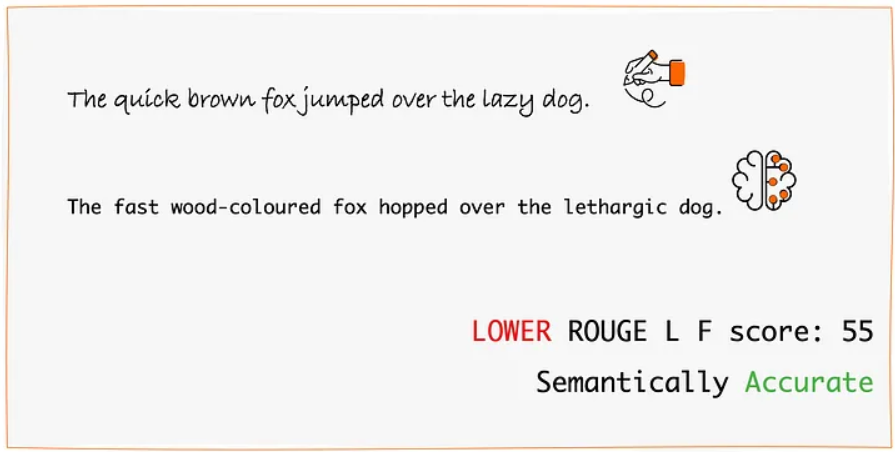

While ROUGE and other evaluation metrics (e.g., BLEU, METEOR, etc) serve as valuable tools for quick and straightforward evaluation of language models, they have certain limitations that render them less than ideal. To begin with, they fall short when it comes to assessing the fluency, coherence, and overall meaning of passages. They are also relatively insensitive to word order. ROUGE primarily measures lexical overlap and may not fully capture the semantic meaning or quality of a summary. For these reasons, researchers are still trying to find improved metrics.

Therefore, these metrics are not shoe-in replacements for human evaluation, but are best used in conjunction with human evaluations for a more comprehensive assessment of summary quality.

## Load dataset

In [ ]:
# Load the dataset from disk
dataset = load_from_disk("./resources/data/Goud-sum/Goud-sum")

For efficiency purposes, we will only load a subset of the dataset for this practical. If you have more time and resources, you can load the entire dataset.

In [ ]:
dataset["train"] = (
    dataset["train"].select(range(1000))
    if torch.cuda.is_available()
    else dataset["train"].select(range(100))
)
dataset["test"] = dataset["test"].select(range(100))
dataset["validation"] = dataset["validation"].select(range(100))

## Check dataset


In [ ]:
print(dataset)

In [ ]:
dataset['train'][0]

# Section 1: Efficiently Fine-Tune Seq2Seq Models with Low Rank Adaptation (LoRA)

The goal of this section is to fine-tune a base model for our summarization task using a parameter efficient mechanism called low-rank adapatation (LoRA). An implementation of this technique is part of the Parameter Efficient Fine-Tuning (PEFT) library from Hugging Face. We will leverage the 🤗 [Transformers](https://huggingface.co/docs/transformers/index), [Accelerate](https://huggingface.co/docs/accelerate/index), and [PEFT](https://github.com/huggingface/peft) in this section.

You will learn how to:

1. Prepare the dataset
2. Fine-Tune Multilingual T5 with LoRA
3. Run inference & Evaluate

### Quick intro to PEFT or Parameter Efficient Fine-tuning:
While large language models (LLMs) have shown remarkable performance across a wide range of NLP tasks, they require significant computation resources to train, fine-tune and deploy. In addition, many real-world use-cases require adapting avialable LLMs to their target task in order to achieve desired performance.

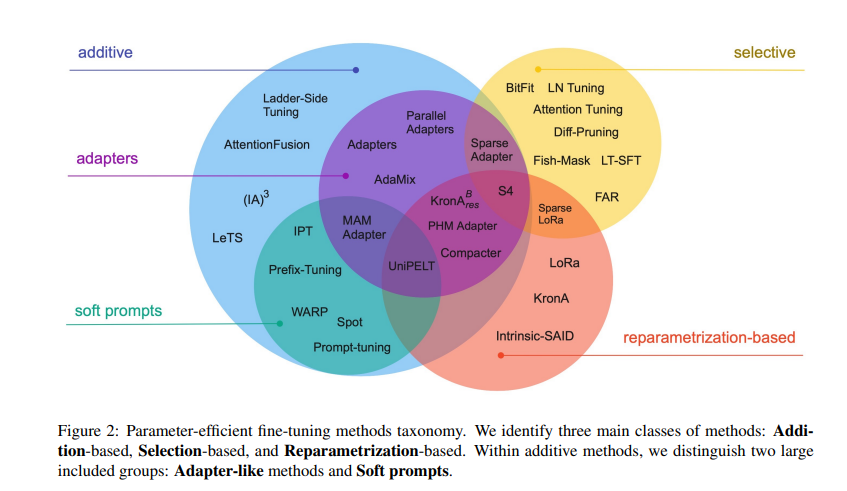

<a href="https://arxiv.org/abs/2303.15647#" target="_blank">PEFT Methods, from the paper "Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning"
</a>

[PEFT](https://github.com/huggingface/peft), or Parameter Efficient Fine-tuning, is a new open-source library from Hugging Face to enable efficient adaptation of pre-trained models, including but not limited to language models and diffusion mdoels, to various downstream applications without needing fine-tuning all the model's parameters. PEFT includes techniques and variants of many methods such as:

- LoRA: [LoRA: Low-Rank Adaptation of Language models](https://arxiv.org/abs/2106.09685)
- Prefix Tuning: [P-Tuning v2: Prompt Tuning Can Be Comparable to Fine-tuning Universally Across Scales and Tasks](https://arxiv.org/abs/2110.07602)
- P-Tuning: [GPT Understands, Too](https://arxiv.org/abs/2103.10385)
- Prompt Tuning: [The Power of Scale for Parameter-Efficient Prompt Tuning](https://arxiv.org/abs/2104.08691)

## Low-Rank Adaptation (LoRA)

While fine-tuning an entire LLM is cost prohibitive, even on small datasets. For example, fully fine-tuning the Llama7B model requires 112GB of VRAM, i.e. at least two 80GB A100 GPUs. Fortunately, parameter efficient fine-tuning methods such as LoRA allow users with meager resources to adapat an LLM to their target task efficiently and effectively.

In this tutorial we explore QLoRA, which is a parameter-efficient fine-tuning technique that reduces the number of parameters fine-tuned during the adaptation process, and additionally introduces quantization to further lower the memory footprint of the adapted model.

### How Does LoRA Work?

The paper [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685) takes inspiration from the conjecture that over-parameterized models span a low-rank intrinsic dimension. A low intrinsic dimension means the data can be effectively represented or approximated by a lower-dimensional space while retaining most of its essential information or structure. In other words, this means we can decompose the new weight matrix for the adapted task into lower-dimensional (smaller) matrices without losing significant information.

Concretely, let us suppose $\delta W$ is the weight update for an $A\times B$ weight matrix. Then, a low-rank decompsoition of $\delta W$ can be expressed as: $\delta W = W_A W_B$, where $W_A$ is an $A\times k$ matrix and $W_B$ is a $k\times B$ matrix. Here, $k$ is the rank of the decomposition, and is typically much smaller than $A$ and $B$.

![Image courtesty from Sebastian Raschka's Ligthning.AI tutorial on LoRA](https://lightningaidev.wpengine.com/wp-content/uploads/2023/04/lora-4-300x226@2x.png)

## Summarization Using MT5

Prior to fine-tuning our model, we need to select the model we will use as our base model. In this case, we will use the [MT5](https://huggingface.co/google/mt5-small) model, which is a multilingual variant of the T5 model. The MT5 model is trained on a large multilingual corpus and is capable of performing a wide range of NLP tasks, including summarization.

In [ ]:
tokenizer = mt5_small["tokenizer"]
model = mt5_small["model"]

Next we prepare our datasets for training. This requires tokenizing the input and output sequences, padding them to the desired length, and then converting them into PyTorch Dataset objects.

In [ ]:
# The maximum total input sequence length after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded.
tokenized_inputs = concatenate_datasets([dataset["train"], dataset["test"]]).map(
    lambda x: tokenizer(x["article"], truncation=True),
    batched=True,
    remove_columns=["categories", "headline"],
)
input_lengths = [len(x) for x in tokenized_inputs["input_ids"]]

In [ ]:
# take 85 percentile of max length for better utilization
max_source_length = int(np.percentile(input_lengths, 85))
print(f"Max source length: {max_source_length}")

In [ ]:
# The maximum total sequence length for target text after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded."
tokenized_targets = concatenate_datasets([dataset["train"], dataset["test"]]).map(
    lambda x: tokenizer(x["headline"], truncation=True),
    batched=True,
    remove_columns=["article", "categories"],
)
target_lengths = [len(x) for x in tokenized_targets["input_ids"]]
# take 90 percentile of max length for better utilization
max_target_length = int(np.percentile(target_lengths, 90))
print(f"Max target length: {max_target_length}")

In [ ]:
def preprocess_function(sample, padding="max_length"):
    # # add prefix to the input for t5
    # tokenize inputs
    model_inputs = tokenizer(
        sample["article"],
        max_length=max_source_length,
        padding=padding,
        truncation=True,
    )

    # Tokenize targets with the `summary` keyword argument
    labels = tokenizer(
        sample["headline"],
        max_length=max_target_length,
        padding=padding,
        truncation=True,
    )

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label]
            for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["headline", "article", "categories"],
)
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")

Finally we need to define our configuration for LoRA. The primary parameters for LoRA are:

* `r`: this is the rank of the decomposed matrices $A$ and $B$ to be learned during fine-tuning. A smaller number will save more GPU memory but might decrease performance.
* `lora_alpha`: this is the weight of the low-rank loss in the total loss function, or the coefficient for the learned $\Delta W$ factor. A larger number will typically result in a larger behavior change after fine-tuning.
* `lora_dropout`: the dropout ratio for layers in the LoRA adapters $A$ and $B$.
* `target_modules`: which modules to learn the low-rank decomposition for. This could be all linear layers, for example, or specific modules in the base network

In [ ]:
lora_config = LoraConfig(
  r=16,
  lora_alpha=32,
  target_modules=["q", "v"],
  lora_dropout=0.05,
  bias="none",
  task_type=TaskType.SEQ_2_SEQ_LM
)
# prepare int-8 model for training
model = prepare_model_for_kbit_training(model)

# add LoRA adaptor
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

In [ ]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8,
    return_tensors='pt'
)

In [ ]:
NUM_EPOCHS = 1
output_dir = "lora-goud-mt5-small"

In [ ]:
# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir="lora-mt5-goud",
    auto_find_batch_size=True,
    learning_rate=1e-3,
    num_train_epochs=NUM_EPOCHS,
    logging_dir=f"{output_dir}/logs",
    logging_strategy="steps",
    logging_steps=500,
    save_strategy="no",
    report_to=["tensorboard",
              #  "wandb",
               ],
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["validation"].select(range(20)),
    tokenizer = tokenizer,
)

In [ ]:
display(HTML(
    """
    <iframe src="https://wandb.ai/alizaidi/huggingface/runs/2rwkxynz?nw=nwuseralizaidi" style="border:none;height:1024px;width:100%">
    """))

In [ ]:
trainer.train()

## Evaluation 1: LoRA mT5 Model


In [ ]:
config = lora_model["config"]
base_model = mt5_small["model"]
model = lora_model["model"]
tokenizer = lora_model["tokenizer"]

In [ ]:
text = dataset["test"][0]["article"]
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    outputs = model.generate(input_ids=inputs["input_ids"], max_new_tokens=128)
    print(
        tokenizer.batch_decode(
            outputs.detach().cpu().numpy(), skip_special_tokens=True
        )[0]
    )

In [ ]:
dataset["test"][0]["headline"]

In [ ]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """
    Split the dataset into smaller batches for processing.

    Args:
        list_of_elements (list): The list to be split into batches.
        batch_size (int): The size of each batch.

    Yields:
        list: A batch of elements from the input list.
    """
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


def calculate_metric_on_test_ds(
    dataset,
    metric,
    model,
    tokenizer,
    batch_size=16,
    device="cuda" if torch.cuda.is_available() else "cpu",
    column_text="article",
    column_summary="highlights",
):
    """
    Calculate evaluation metrics on the test dataset.

    Args:
        dataset (Dataset): The dataset to evaluate on.
        metric (Metric): The metric to use for evaluation.
        model (PreTrainedModel): The model to use for generation.
        tokenizer (PreTrainedTokenizer): The tokenizer for the model.
        batch_size (int): The batch size for processing.
        device (str): The device to use for computation.
        column_text (str): The name of the column containing the input text.
        column_summary (str): The name of the column containing the target summary.

    Returns:
        dict: A dictionary containing the computed metrics.
    """
    model.to(device)
    article_batches = list(
        generate_batch_sized_chunks(dataset[column_text], batch_size)
    )
    target_batches = list(
        generate_batch_sized_chunks(dataset[column_summary], batch_size)
    )

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)
    ):

        inputs = tokenizer(
            article_batch,
            max_length=512,
            truncation=True,
            padding=True,
            return_tensors="pt",
        ).to(device)

        summaries = model.generate(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
            # length_penalty=0.8,
            # num_beams=8,
            # max_length=128,
        )
        """ parameter for length penalty ensures that the model does not generate sequences that are too long. """

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [
            tokenizer.decode(
                s, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            for s in summaries
        ]

        decoded_summaries = [
            d.replace("", " ").strip().lower() for d in decoded_summaries
        ]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score


def evaluation(tokenizer, model, dataset):
    """
    Evaluate the model on the dataset using ROUGE metrics.

    Args:
        tokenizer (PreTrainedTokenizer): The tokenizer for the model.
        model (PreTrainedModel): The model to evaluate.
        dataset (Dataset): The dataset to evaluate on.

    Returns:
        dict: A dictionary containing the ROUGE scores.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # loading data
    rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
    rouge_metric = load("rouge", trust_remote_code=True)
    score = calculate_metric_on_test_ds(
        dataset["test"][0:50],
        rouge_metric,
        model,
        tokenizer,
        batch_size=2,
        column_text="article",
        column_summary="headline",
        device=device,
    )


    return score

In [ ]:
evaluation(tokenizer, model, dataset)

## Evaluation 2: Evaluation on Already-Finetuned Bert-Based Models


In this section, we will compare the performance of our fine-tuned mt5 model against BERT-based models that were fine-tuned on the Goud-sum datase ( [AraBERT](https://huggingface.co/Goud/AraBERT-summarization-goud), [DziriBERT](https://huggingface.co/Goud/DziriBERT-summarization-goud), and [DarijaBERT](https://huggingface.co/Goud/DarijaBERT-summarization-goud)).

Prior to fine-tuning, those models were pre-trained on large corpora of Arabic text. This means they have a deep understanding of the Arabic language structure, vocabulary, and nuances. In contrast, mt5 is a multilingual model that covers many languages, potentially sacrificing depth for breadth in language understanding.

Refer to the [github.com/issam9/goud-summarization-dataset](https://github.com/issam9/goud-summarization-dataset) repository for the training code for the workshop paper [Goud.ma: a News Dataset for Summarization in Moroccan Darija](https://openreview.net/forum?id=BMVq5MELb9).




In [ ]:
# List of models to evaluate
models = [
    "Goud/AraBERT-summarization-goud",
    "Goud/DziriBERT-summarization-goud",
    "Goud/DarijaBERT-summarization-goud"
]

In [ ]:
# Evaluate each model
for model_name in models:
    print(f"Evaluating model: {model_name}")

    # Load the appropriate model and tokenizer based on the model name
    if "AraBERT" in model_name or "DziriBERT" in model_name or "DarijaBERT" in model_name:
        # tokenizer = AutoTokenizer.from_pretrained(model_name) # pull directly from HuggingFace
        tokenizer = bert_models[f"{model_name}"]["tokenizer"] # load from locally available tokenizers
        tokenizer.model_max_length = 1024
        # model = EncoderDecoderModel.from_pretrained(model_name) # pull directly from HuggingFace
        model = bert_models[f"{model_name}"]["model"] # load from previously downloaded models
        model.config.max_position_embeddings = 1024
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device) # move model to appropriate device


    rouge_scores = evaluation(tokenizer, model, dataset)
    print(f"ROUGE scores for {model_name}:")
    print(rouge_scores)
    print("\n")

# Activity: Native Language Article Summarization

**Task:** Fetch an article in your native language and assess the summarization and headline generation capabilities of ChatGPT.

**Steps:**

1. **Select an Article:** Choose a relevant and recent article written in your native language. Ensure it is of short or medium length.

2. **Summarize with ChatGPT:** Use ChatGPT to generate a summary of the selected article.

3. **Evaluate Summarization Quality:**
    - **Impression:** Share your impression of the summarization quality. Consider the following:
        - **Accuracy:** Does the summary capture the main points and essence of the article?
        - **Clarity:** Is the summary clear and easy to understand?
        - **Coverage:** Does the summary include all critical information from the article?

4. **Provide Feedback:** Offer constructive feedback on the summarization. Highlight any discrepancies or areas for improvement.


In [ ]:
# @title Generate Quiz Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/sggLJWMFQ4JQCmHL8",
  width="80%"
	height="320px" >
	Loading...
</iframe>
"""
)

# Section 2: Summarization using GPT

In this section, we will employ OpenAI's models to perform abstractive text summarization. Following this, we will evaluate the performance of these models and compare the results with those obtained from the models discussed in Section 1. This execise will provide us with baseline numbers to compare with the results from section 1.

Unlike traditional fine-tuning approaches, which involve updating the model's weights, adapting a GPT-based model for a specific task begins with prompt engineering. This technique does not require modifying the model’s internal parameters. Instead, prompt engineering involves crafting specific instructions for the model to follow, guiding it to perform a desired task. When examples are provided within the prompt, this method is referred to as few-shot prompting (Brown et al., 2020).

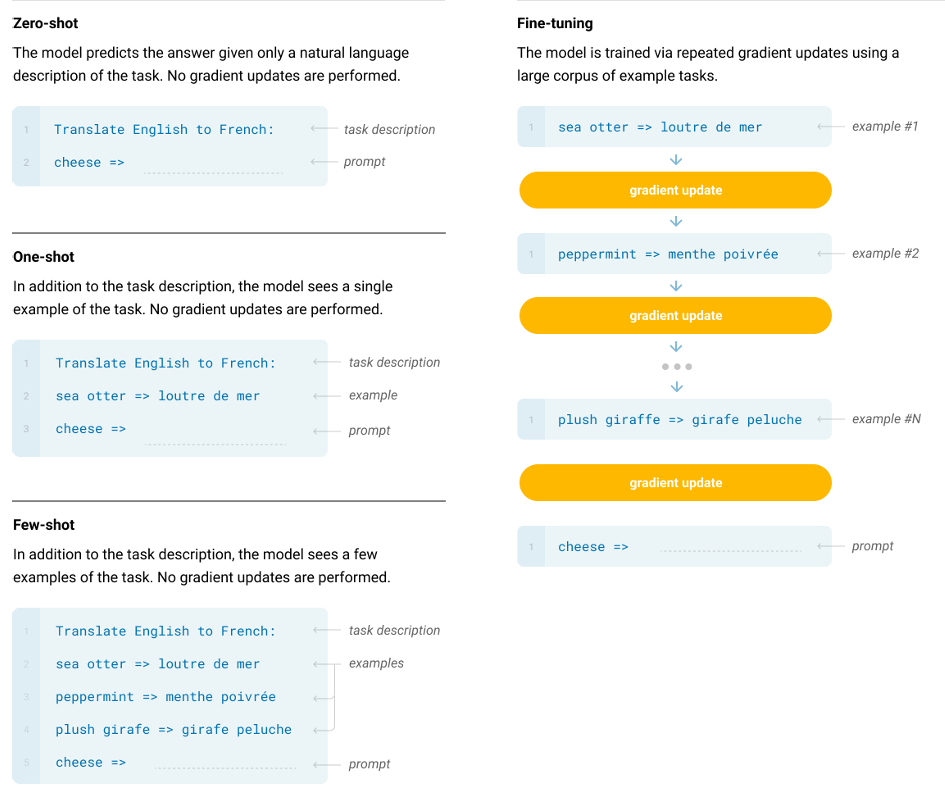

<a href="https://arxiv.org/pdf/2005.14165" target="_blank">Prompting Vs Traditional fine-tuning diagram from the paper "Language Models are Few-Shot Learners"</a>

We will now define a function that can be used for 0 or few-shot prompting, depending on parameters you provide. The function creates a list of structured messages, including both a *system message* and a series of *user-assistant* dialogue pairs.

A **system message** is a special type of message used to establish the context, guidelines, or rules that the model should follow while generating responses. It informs the AI model about the specific task, the kind of responses expected, and any other relevant instructions.

**User-assistant dialogue pairs** refer to exchanges between the user (the person or entity interacting with the AI) and the assistant (the AI model). These pairs consist of a prompt or question posed by the user and the corresponding reply from the assistant, demonstrating how the model should respond to similar inputs.

These messages are used to provide the AI model with examples of how to transform a news article into a clickbait headline in Moroccan Darija. In this scenario, we are going to pick the examples once, randomly, and fix them for all test examples. That said, there are several other approaches to picking examples for few-shot prompting.


In [ ]:
import random
def create_prompt_messages(train_source, train_target, max_shots):
    """Create prompt messages for the model, including training examples."""
    messages = [
        {
            "role": "system",
            "content": "You are asked to summarize a news article written in Modern Standard Arabic and Moroccan Darija, and write that summary as a clickbait headline, in Moroccan Darija only.\n"
        }
    ]
    for _ in range(max_shots):
        idx = random.choice(range(len(train_source)))
        train_src = train_source[idx]
        train_tgt = train_target[idx]
        messages.extend([
            {
                "role": "user",
                "content": f"Summarize the following news article into a headline in Moroccan Darija only:\n\"{train_src}\""
            },
            {
                "role": "assistant",
                "content": f"Absolutely! Here is the headline summarizing your news article:\n\"{train_tgt}\""
            }
        ])
    return messages

In [ ]:
# Define necessary variables
key = ""
model_name = "gpt-4o-mini"
shots_count = 5 #you may edit this
output_filename = f"./outputs/Goud_{model_name}_test_generated_{shots_count}.csv"

Create base prompt

In [ ]:
train_source = dataset["train"]["article"]
train_target = dataset["train"]["headline"]
base_prompt = create_prompt_messages(train_source, train_target, shots_count)

## Execute the summarization on sample of Goud-sum
For the sake of time we will be selecting a small subet of the Goud-sum test set and use it to demonstrate inference and evaluation of a GPT-based model. Specifically, GPT4o-mini.

In [ ]:
test_source = dataset["test"]["article"]
test_target = dataset["test"]["headline"]
summarize_news_article(test_source, base_prompt, output_filename, model_name, key, shots_count)

## Evaluation of GPT4o-mini on sample of Goud-sum

Define evaluation function


In [ ]:
def evaluate_rouge(hypotheses, references):
    these_refs = [[ref.strip().lower()] for ref in references]
    rouge = PyRouge(rouge_n=(1, 2), rouge_l=True)
    scores = rouge.evaluate(hypotheses, these_refs)
    print(scores)

Run evaluation

In [ ]:
hypotheses = pd.read_csv(output_filename, encoding = "UTF-8")["generated_headline"].tolist()
hypotheses = [substring_after_colon(hypo).replace("\"", "").strip() for hypo in hypotheses]
references = test_target
evaluate_rouge(hypotheses, references)

## Evaluate Previously Generated GPT4 output on entire Goud-sum test set


We have provided pre-generated GPT4 outputs produced by running summarization on the entire Goud-sum dataset.
You will find them in the "resources/generated_responses".The files correspond to outputs from 0,1,5,20 shot prompts.

Replicate the 0-Shot evaluation below on another of the pre-generated outputs.

After running ROUGE evaluation on the responses from a few-shot prompt, add the results to the table of results provided below.

Since the pre-generated responses were created for the entire Goud-sum dataset, and we've only been using a sample so far, we'll need to reload the full dataset to run the evaluation.

In [ ]:
# Load the dataset from disk
dataset = load_from_disk("./resources/data/Goud-sum/Goud-sum")

### ROUGE Metric Results: 0 Shot

| Metric   | Recall (r)         | Precision (p)       | F-Score (f)         |
|----------|--------------------|---------------------|---------------------|
| ROUGE-1  | 0.11077684075270805 | 0.09135489470312334 | 0.10013278320384944 |
| ROUGE-2  | 0.023609648334724228| 0.018883153504743545| 0.020983535770687813|
| ROUGE-L  | 0.1016114619002537  | 0.08367860928881776 | 0.09177724165199    |



In [ ]:
zero_shot_responses_path = "./resources/generated_responses/gpt4/Goud_test_generated_0.csv"
hypotheses = pd.read_csv(zero_shot_responses_path, encoding = "UTF-8")["generated_headline"].tolist()
hypotheses = [substring_after_colon(hypo).replace("\"", "").strip() for hypo in hypotheses]
references = dataset["test"]["headline"]
evaluate_rouge(hypotheses, references)


### ROUGE Metric Results: Few-Shot
Pick **one** or **more** of the files that have the previously generated N-shot GPT responses, present in the "resources/generated_responses" folder, run the evaluation and then populate the table below

| Metric   | Recall (r)        | Precision (p)     | F1-Score (f)      |
|----------|-------------------|-------------------|-------------------|
| ROUGE-1  |             |             |             |
| ROUGE-2  |            |             |            |
| ROUGE-L  |             |             |           |


In [ ]:
n_shot_responses_path = ""
hypotheses = pd.read_csv(n_shot_responses_path, encoding = "UTF-8")["generated_headline"].tolist()
hypotheses = [substring_after_colon(hypo).replace("\"", "").strip() for hypo in hypotheses]
references = dataset["test"]["headline"]
evaluate_rouge(hypotheses, references)

In [ ]:
# @title Generate Quiz Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/C99ANyuNu23ZdZ7G7",
  width="80%"
	height="600px" >
	Loading...
</iframe>
"""
)

## Conclusion
**Summary:**

In this practical, we explored the realm of low-resource LLMs, demonstrating how parameter-efficient fine-tuning techniques and quantization can save resources during both training and inference. We showed how state-of-the-art GPT-based models can perform the same summarization task through API calls and compared their results with those obtained in a resource-constrained setting.

Our conclusion is that, for the dataset at hand, the results from the fine-tuned models and GPT models are comparable, indicating that, for a dataset in a low-resource language or domain, parameter-efficient fine-tuning (PEFT) can be an effective approach to achieve high performance without the need for extensive computational resources.

**Next Steps:**

[Next steps for people who have completed the prac, like optional reading (e.g. blogs, papers, courses, youtube videos). This could also link to other pracs.]

**Appendix:**

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.]

**References:**

[References for any content used in the notebook.]

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2024).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/WUpRupqfhFtbLXtN6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />